## Classify Handwritten Digits with LeNet/BigDL

In [1]:
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from bigdl.dataset import mnist
from bigdl.util.common import init_engine, Sample

from bigdl.nn.layer import Linear, SpatialMaxPooling, \
    SpatialConvolution, ReLU, Sequential, Reshape, LogSoftMax
    
from bigdl.optim.optimizer import Optimizer, Adam, MaxEpoch, EveryEpoch, Top1Accuracy, \
    TrainSummary, ValidationSummary, SeveralIteration, SGD

from bigdl.nn.criterion import ClassNLLCriterion, CrossEntropyCriterion

In [2]:
sc

In [3]:
init_engine()

In [4]:
MNIST_PATH = 'MNIST_data'
(train_images, train_labels) = mnist.read_data_sets(MNIST_PATH, "train")
(test_images, test_labels) = mnist.read_data_sets(MNIST_PATH, "test")

('Extracting', 'MNIST_data/train-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/train-labels-idx1-ubyte.gz')
('Extracting', 'MNIST_data/t10k-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/t10k-labels-idx1-ubyte.gz')


In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

#### Print Digits

3243
8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  28 127 209 216  83   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  16 103 232 253 253 253 245  33   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  13 213 254 253 228 112 253 235  27   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 220 253 244 124 138 237 222  53   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  99 248 253  83   0 108

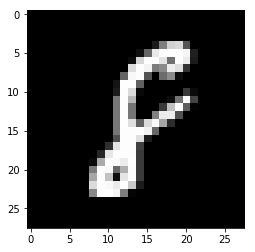

In [6]:
np.set_printoptions(threshold=1000, linewidth=10000)

def display(X, y, n):
    pic = X[n].reshape(28, 28)
    plt.imshow(pic, cmap='gray')
    with pd.option_context("display.max_columns", 1000):
        print(n)
        print(y[n])
        print(pic)
    
n = np.random.randint(0, train_images.shape[0])
display(train_images, train_labels, 3243)

In [7]:
CLASS_COUNT = len(np.unique(train_labels))
assert len(np.unique(train_labels)) == CLASS_COUNT
CLASS_COUNT

10

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Normalize data

Data normalization helps the numerical algorithms to converge faster (or at all).
Our data is in range [0, 255]; we will normalize it to be in the range [0.1, 0.9].

In [9]:
def normalize(image_data, labels, min_x=None, max_x=None):
    min_x = np.min(image_data) if min_x is None else min_x
    max_x = np.max(image_data) if max_x is None else max_x
    delta = max_x - min_x
    a, b = 0.1, 0.9

    rdd_images = sc.parallelize(image_data)
    rdd_labels = sc.parallelize(labels)

    rdd_sample = rdd_images \
        .zip(rdd_labels) \
        .map(lambda (features, label): \
             Sample.from_ndarray((features - min_x) * (b - a) / delta, label + 1))
    return rdd_sample, min_x, max_x

#### Normalize data.
Use Min/Max normalization to improve convergence.

In [10]:
X_train_norm, min_x, max_x = normalize(train_images, train_labels)

**Important**: apply the same Min/Max values from the training set to the testing set:

In [11]:
X_test_norm, _, _ = normalize(test_images, test_labels, min_x, max_x)

In [13]:
# X_test_norm.shape

Inspect samples:

In [14]:
# samples = X_test_norm.collect()

In [15]:
# samples[0]

In [16]:
def LeNet(class_num):
    model = Sequential()
    model.add(Reshape([1, 28, 28]))
    
    model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))
    model.add(ReLU())
    
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
    
    model.add(SpatialConvolution(6, 16, 5, 5).set_name('conv2'))
    model.add(ReLU())
    
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))
    
    model.add(Reshape([16 * 4 * 4]))
    
    model.add(Linear(16 * 4 * 4, 84).set_name('fc1'))
    model.add(ReLU())

#     model.add(Linear(120, 84).set_name('fc2'))
#     model.add(ReLU())

    model.add(Linear(84, class_num).set_name('score'))
    model.add(LogSoftMax())
    
    return model

In [17]:
lenet_model = LeNet(CLASS_COUNT)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


#### Hyperparameters

In [18]:
EPOCHS = 3

Create training loop:

In [19]:
optimizer = Optimizer(model=lenet_model, training_rdd=X_train_norm,
                      criterion=ClassNLLCriterion(),
                      optim_method=SGD(nesterov=True, momentum=0.9, dampening=0.0),
                      end_trigger=MaxEpoch(EPOCHS),
                      batch_size=64)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer


In [20]:
# Set the validation logic
optimizer.set_validation(batch_size=128, val_rdd=X_test_norm,
                         trigger=EveryEpoch(),
                         val_method=[Top1Accuracy()])

creating: createEveryEpoch
creating: createTop1Accuracy


In [21]:
import shutil
from os import path

LOG_DIR = '/tmp/bigdl_summaries'
APP_NAME='lenet5-' # + datetime.now().strftime("%Y%m%d-%H%M%S")
try:
    shutil.rmtree('/private' + LOG_DIR + '/' + APP_NAME)
except:
    pass

In [ ]:
train_summary = TrainSummary(log_dir=LOG_DIR, app_name=APP_NAME)
train_summary.set_summary_trigger("Parameters", SeveralIteration(10)) 
val_summary = ValidationSummary(log_dir=LOG_DIR, app_name=APP_NAME)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ", APP_NAME)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'lenet5-')


#### Start training

In [ ]:
%%time
trained_model = optimizer.optimize()
print("Done")

In [ ]:
import random
predictions = trained_model.predict(X_test_norm)

In [ ]:
preds = predictions.collect()

In [ ]:
pred_classes = [np.argmax(p) for p in preds]
pred_classes[:10]

In [ ]:
def display_letter_predict(pred_classes):
    N = test_images.shape[0]
    i = random.randint(0, N)
    image = test_images[i]
    pred = pred_classes[i]
    print('Prediction:', pred)
    display(test_images, test_labels, i)

display_letter_predict(pred_classes)

#### Problem:

Find several example from the test prediction where we incorrectly predicted the letter.